In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.evaluate_energymodels import evaluate_different_energymodels

from energy_consumption.help_functions.get_energy_data import get_data
from energy_consumption.help_functions.dummy_mapping import get_mappings
from energy_consumption.models.time_series_models.lasso_regression import get_lasso_forecasts
from energy_consumption.models.time_series_models.QR_mappings_interactions import get_QR_mappings_interactions
from energy_consumption.models.combination.combined_DEMO import get_combined_DEMO
from energy_consumption.models.final_models.SARIMAX import get_SARIMAX_forecasts
from energy_consumption.models.time_series_models.seasonal_QR_hh import get_seasonal_QR_hourly_holidays

In [2]:
energydata = get_data(num_years=1)

100%|██████████| 52/52 [00:33<00:00,  1.57it/s]


In [3]:
energydata

,energy_consumption
date_time,
2023-01-09 00:00:00,43.54425
2023-01-09 01:00:00,42.54900
2023-01-09 02:00:00,42.21750
2023-01-09 03:00:00,42.48775
2023-01-09 04:00:00,44.00125
...,...
2023-12-27 08:00:00,48.69925
2023-12-27 09:00:00,50.96950
2023-12-27 10:00:00,52.04400


In [4]:
# Functions work
lasso = {
    'name': 'lasso regression and interaction',
    'function': get_lasso_forecasts
}
quantile_regression = {
    'name': 'quantile regression',
    'function': get_QR_mappings_interactions
}
SARIMAX_model = { 
    'name': 'SARIMA', 
    'function': get_SARIMAX_forecasts
}
models = [quantile_regression, SARIMAX_model]
evaluation = evaluate_different_energymodels(
    models, energydata, last_x=5, years=False, months=False, weeks=True)

*********** Start the evaluation of model quantile regression***********


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\help_functions\dummy_mapping.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df['month'] = energy_df.index.month


DatetimeIndex(['2023-12-22 12:00:00', '2023-12-22 16:00:00',
               '2023-12-22 20:00:00', '2023-12-23 12:00:00',
               '2023-12-23 16:00:00', '2023-12-23 20:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)
DatetimeIndex(['2023-12-15 12:00:00', '2023-12-15 16:00:00',
               '2023-12-15 20:00:00', '2023-12-16 12:00:00',
               '2023-12-16 16:00:00', '2023-12-16 20:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)
DatetimeIndex(['2023-12-08 12:00:00', '2023-12-08 16:00:00',
               '2023-12-08 20:00:00', '2023-12-09 12:00:00',
               '2023-12-09 16:00:00', '2023-12-09 20:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)
*********** Start the evaluation of model SARIMA***********


MissingDataError: exog contains inf or nans

### Visualize Comparison 

1. Create a table that only contains the different scores of the different models

In [37]:
models[0]['evaluation']['horizon']

date_time
2023-12-22 12:00:00    36 hour
2023-12-22 16:00:00    40 hour
2023-12-22 20:00:00    44 hour
2023-12-23 12:00:00    60 hour
2023-12-23 16:00:00    64 hour
2023-12-23 20:00:00    68 hour
2023-12-15 12:00:00    36 hour
2023-12-15 16:00:00    40 hour
2023-12-15 20:00:00    44 hour
2023-12-16 12:00:00    60 hour
2023-12-16 16:00:00    64 hour
2023-12-16 20:00:00    68 hour
2023-12-08 12:00:00    36 hour
2023-12-08 16:00:00    40 hour
2023-12-08 20:00:00    44 hour
2023-12-09 12:00:00    60 hour
2023-12-09 16:00:00    64 hour
2023-12-09 20:00:00    68 hour
Name: horizon, dtype: object

In [39]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

2.  Plot the densities of the obtained scores

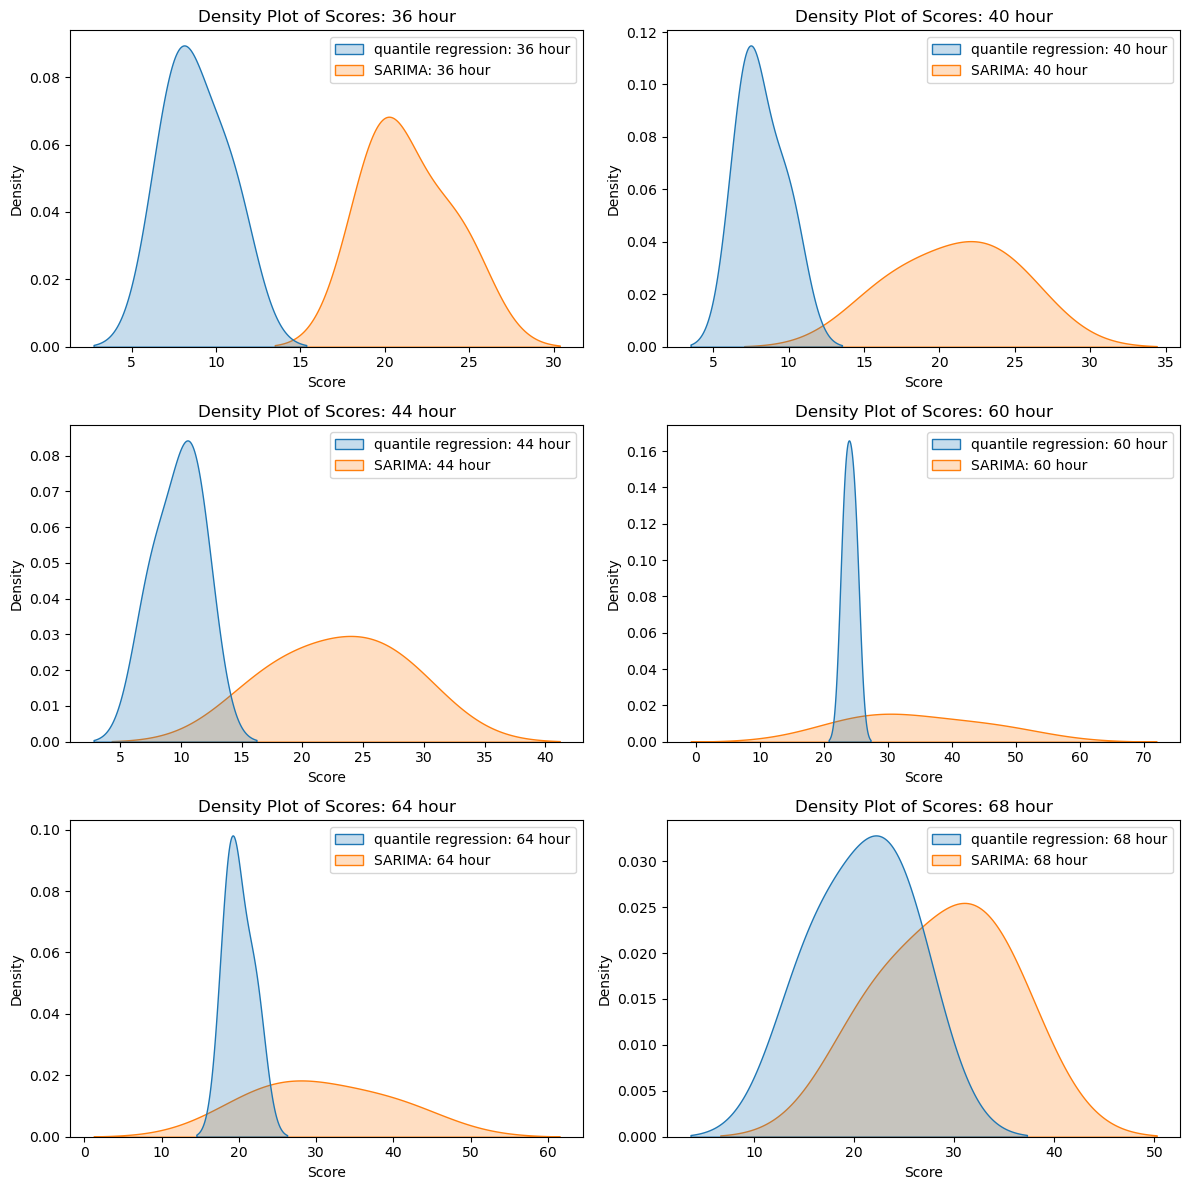

In [40]:
# Create subplots
fig, axes = plt.subplots(3,2, figsize=(12,12))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through each horizon
for i, h in enumerate(horizons):
    # Select columns related to the current horizon
    relevant_cols = [f'{m["name"]}: {h}' for m in models]

    # Filter the relevant data for the current horizon
    data_subset = score_df.loc[:, relevant_cols]

    # Create a KDE plot for the current horizon
    sns.kdeplot(data=data_subset, fill=True, ax=axes[i])

    # Set labels and title for each subplot
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot of Scores: {h}')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plots
plt.show()

Interpretation: Für Freitag ist timely besser, für Samstag nicht

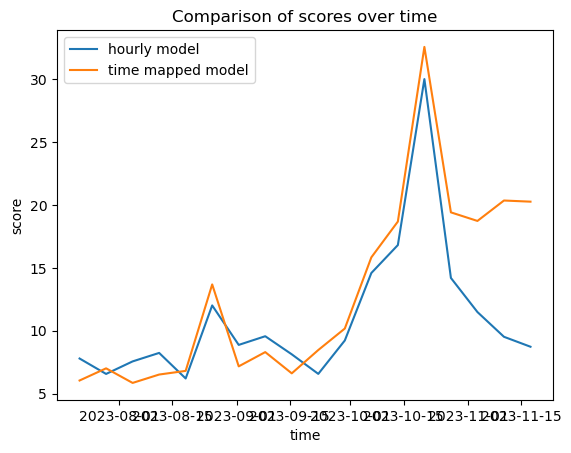

In [14]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['seasonal model hourly: 36 hour'].notna(
)]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model hourly: 36 hour'], label='hourly model')

plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model with time mapping: 36 hour'], label='time mapped model')

# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()